In [3]:
!pip install unrar
!unrar x /content/Dataset2.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Dataset2.rar

Creating    Dataset 2                                                 OK
Creating    Dataset 2/faringitis                                      OK
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.5818f7fd9c45883c801d938b09b29755.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.a04e34f6d58fe952bc090614f030910c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.b120ee8edff9c00d1f305d865b733a42.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.6bd81eac38835aee94df9c1e5079d67c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.873f55c8af860852930aef580ce9463d.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.c1c8132c26736bc54117fbc7d64a2714.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1583073772026_jpeg.rf.61c

In [30]:
!unrar x "/content/kt_dir.rar" "/content/kt_dir/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/kt_dir.rar

Creating    /content/kt_dir                                           OK
Creating    /content/kt_dir/content                                   OK
Creating    /content/kt_dir/content/kt_dir                            OK
Creating    /content/kt_dir/content/kt_dir/pharyngitis_vgg16          OK
Creating    /content/kt_dir/content/kt_dir/pharyngitis_vgg16/trial_13  OK
Extracting  /content/kt_dir/content/kt_dir/pharyngitis_vgg16/trial_13/checkpoint.weights.h5       0%  1%  2%  3%  4%  OK 
Extracting  /content/kt_dir/content/kt_dir/pharyngitis_vgg16/trial_13/build_config.json       4%  OK 
Extracting  /content/kt_dir/content/kt_dir/pharyngitis_vgg16/trial_13/trial.json       4%  OK 
Creating    /content/kt_dir/content/kt_dir/pharyngitis_vgg16/trial_02  OK
Extracting  /content/kt_dir/content/kt_dir/pharyngitis_vgg16/trial_02/checkpoint.weig

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


base_dir = '/content/Dataset 2'  

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
  
  directory = base_dir,
  labels = 'inferred',
  label_mode = 'int',
  batch_size = 32,
  image_size = (224, 224),
  verbose = True
)
normalization_layer = tf.keras.layers.Rescaling(1./255)
data = data.map(lambda x, y: (normalization_layer(x), y)) 

dataset_size = len(data)


train_size = int(0.7 * dataset_size) 
validation_size = int(0.2 * dataset_size) 
test_size = dataset_size - train_size - validation_size 

train = data.take(train_size) 
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size)

Found 2460 files belonging to 2 classes.


In [27]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 2116 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Model

def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units1', min_value=64, max_value=512, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1))(x)
    x = Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
    x = Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='pharyngitis_vgg16'
)

Reloading Tuner from kt_dir/pharyngitis_vgg16/tuner0.json


In [ ]:

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# tuner.search(train_generator, epochs=50, validation_data=valid_generator, callbacks=[stop_early])

In [ ]:
!rar a "/content/kt_dir" "/content/kt_dir"


RAR 6.23   Copyright (c) 1993-2023 Alexander Roshal   1 Aug 2023
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Creating archive /content/kt_dir.rar

Adding    /content/kt_dir/pharyngitis_vgg16/trial_13/checkpoint.weights.h5       0%  1%  2%  3%  4%  OK 
Adding    /content/kt_dir/pharyngitis_vgg16/trial_13/build_config.json       4%  OK 
Adding    /content/kt_dir/pharyngitis_vgg16/trial_13/trial.json            4%  OK 
Adding    /content/kt_dir/pharyngitis_vgg16/trial_02/checkpoint.weights.h5       5%  6%  7%  8%  9% 10%  OK 
Adding    /content/kt_dir/pharyngitis_vgg16/trial_02/build_config.json      10%  OK 
Adding    /content/kt_dir/pharyngitis_vgg16/trial_02/trial.json           10%  OK 
Adding    /content/kt_dir/pharyngitis_vgg16/trial_03/checkpoint.weights.h5      10% 11% 12% 13% 14% 15%  OK 
Adding    /content/kt_dir/pharyng

In [33]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │       229,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,059,713 (57.45 MB)

 Trainable params: 345,025 (1.32 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
test_loss, test_acc = best_model.evaluate(test)
print(f'Test Accuracy: {test_acc:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 619ms/step - accuracy: 0.8065 - loss: 0.4087
Test Accuracy: 0.80


In [35]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters:")
print(f" - units1: {best_hps.get('units1')}")
print(f" - units2: {best_hps.get('units2')}")
print(f" - dropout1: {best_hps.get('dropout1')}")
print(f" - dropout2: {best_hps.get('dropout2')}")
print(f" - Learning Rate: {best_hps.get('lr')}")

Best hyperparameters:
 - units1: 448
 - units2: 256
 - dropout1: 0.4
 - dropout2: 0.30000000000000004
 - Learning Rate: 0.0001


In [ ]:

best_model = tuner.hypermodel.build(best_hps)

for layer in best_model.layers:
    if layer.name.startswith('block5_') or layer.name.startswith('block4_'):
        layer.trainable = True
history = best_model.fit(
    train,
    validation_data=validation,
    epochs=100,
    batch_size=32,
    callbacks=stop_early,
    verbose=1
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.6391 - loss: 0.6204 - val_accuracy: 0.8125 - val_loss: 0.4585
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8426 - loss: 0.3866 - val_accuracy: 0.9208 - val_loss: 0.1963
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9469 - loss: 0.1761 - val_accuracy: 0.9396 - val_loss: 0.1585
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9488 - loss: 0.1498 - val_accuracy: 0.9542 - val_loss: 0.1206
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9687 - loss: 0.0900 - val_accuracy: 0.9604 - val_loss: 0.1055
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9661 - loss: 0.0949 - val_accuracy: 0.9542 - val_loss: 0.1249
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9635 - loss: 0.0924 - val_accuracy: 0.9688 - val_loss: 0.1054
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9892 - loss: 0.0423 - val_accuracy: 0

In [ ]:
best_model.save('tuner_vgg16_pharyngitis_model2.keras')

In [38]:
best_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 448)            │       229,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 41,708,165 (159.10 MB)

 Trainable params: 13,324,225 (50.83 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

 Optimizer params: 26,648,452 (101.66 MB)

In [40]:
test_loss, test_acc = best_model.evaluate(test)
print(f'Test Accuracy: {test_acc:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9645 - loss: 0.0761
Test Accuracy: 0.96


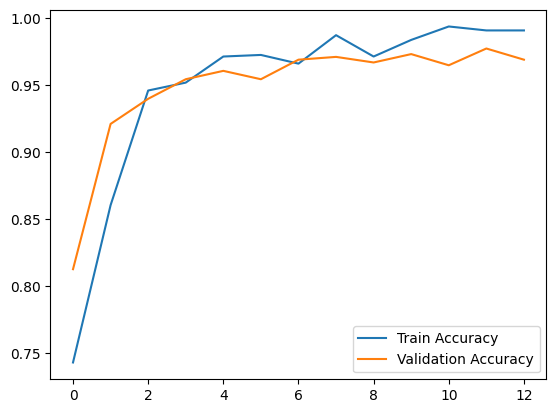

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


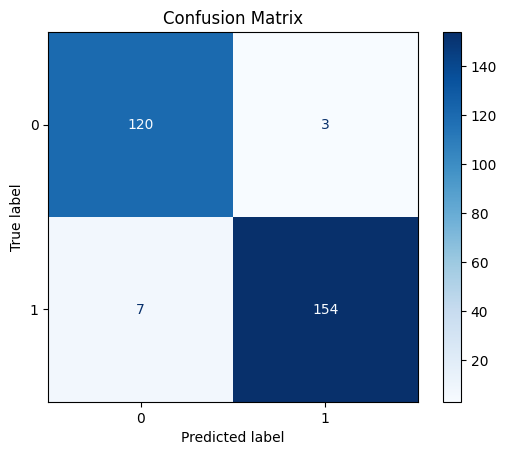

In [ ]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt



true_labels = []
predictions = []

for images, labels in test:
  true_labels.extend(labels.numpy())
  preds = best_model.predict(images)
  predictions.extend(preds.flatten())


binary_predictions = np.round(predictions).astype(int)


cm = confusion_matrix(true_labels, binary_predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:


from sklearn.metrics import classification_report


report = classification_report(true_labels, binary_predictions)


print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       123
           1       0.98      0.96      0.97       161

    accuracy                           0.96       284
   macro avg       0.96      0.97      0.96       284
weighted avg       0.97      0.96      0.96       284



In [49]:
best_model.save('tuner_noaug_vgg16_pharyngitis_model2.keras')